## Pre-Processing

In [1]:
from source import data_import
from source.constants import CHANNELS, DEFAULT_PATIENTS
import numpy as np
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt

from source.filter_eeg_channels import filter_eeg_channels
from source.calculate_mean_psd import calculate_mean_psd
from source.calculate_mean_wavelet_energy import calculate_mean_wavelet_energy
from source.constants import CHANNELS, FREQUENCY_RANGES
                                            
from sklearn.preprocessing import StandardScaler, minmax_scale, MinMaxScaler

In [2]:
def load_file(file_name):
    if file_name.endswith('.arrow'):
        return data_import.load_pyarrow(file_name=file_name)
    elif file_name.endswith('.npy'):
        print('loading npy')
        return np.load('data/' + file_name, allow_pickle=True)
    else:
        print('no filename provided, trying npy')
        try:
            np.load('data/' + file_name + '.npy', allow_pickle=True)
        except FileNotFoundError:
            print('no npy file found, trying arrow')
            return data_import.load_pyarrow(file_name=file_name + '.arrow')
        
def save_file(data, file_name):
    if file_name is None:
        print('skipping save file.')
    elif file_name.endswith('.arrow'):
        data_import.save_pyarrow(data, file_name=file_name)
    elif file_name.endswith('.npy'):
        print('saving npy')
        np.save('data/' + file_name, data)
    else:
        print('no filetype provided, saving as npy')
        np.save('data/' + file_name + '.npy', data)

In [3]:
## PARAMETERS ##
SKIP_DATA = True
data_filename = "preprocessed_seg_all_60.arrow" # data will be loaded/saved with this filename. Put None to skip saving the file

SKIP_FEATURES = False
feature_filename = 'extracted_features.npy' # data will be loaded/saved with this filename. Put None to skip saving the file

### DATA ###
# Load Patient Data #
patient_ids = DEFAULT_PATIENTS #DEFAULT_PATIENTS # use DEFAULT_PATIENTS for default patients selection
nr_segments=60
segment_duration=1
ictal_segmentation_foo=data_import.preictal_segmentation
interictal_segmentation_foo=data_import.inter_segmentation
channels=CHANNELS
seizure_offset=0

# filter #
exclude_ranges=[[58, 62], [118, 122]]

### FEATURES ###
target_colname = 'target'
PRED_INTERVAL = 6000 # how long should a segment count as preictal in seconds

window_size = 30 # Define the sequence_train window size

In [4]:
if not SKIP_DATA:
    # Load Patient Data
    p_df = data_import.load_segmented_data(patient_ids=patient_ids,
                                            nr_segments=nr_segments,
                                            segment_duration=segment_duration,
                                            ictal_segmentation_foo=data_import.preictal_segmentation,
                                            interictal_segmentation_foo=data_import.inter_segmentation,
                                            channels=channels,
                                            seizure_offset=seizure_offset
                                            )
    
    # Filter
    fit_df = filter_eeg_channels(p_df, CHANNELS, fs=256, exclude_ranges=exclude_ranges, Q=30)
    pd_toconcat = p_df[['epoch', 'segment_id']]
    fit_df = pd.concat(objs=[fit_df, pd_toconcat], axis =1)
    save_file(data=fit_df, file_name=data_filename)
else:
    fit_df = load_file(data_filename)
    fit_df = pd.DataFrame(fit_df)
fit_df.head()

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/preprocessed_seg_all_60.arrow was loaded.


channel,F4-C4,F3-C3,FT9-FT10,FZ-CZ,F7-T7,FP2-F4,T8-P8-1,T8-P8-0,FP1-F3,CZ-PZ,before_seizure,is_seizure,target,epoch,segment_id
0 days 00:30:00,16.878726,20.334213,-3.322584,17.941953,18.739373,33.092935,12.625819,12.625819,44.788430,2.790970,False,False,0 days,0,0
0 days 00:30:00.003906250,22.891349,24.865283,-8.175141,23.784967,26.448730,40.639022,11.874291,11.874291,59.506243,4.538652,False,False,0 days,0,0
0 days 00:30:00.007812500,22.162881,25.360125,-8.902114,25.615925,27.023819,40.074853,5.285063,5.285063,60.136641,5.292160,False,False,0 days,0,0
0 days 00:30:00.011718750,29.573426,33.953147,-14.930178,33.038895,32.700204,52.956037,8.308854,8.308854,79.842157,8.558853,False,False,0 days,0,0
0 days 00:30:00.015625,21.292400,18.163275,-11.955401,21.366748,20.938086,35.328903,-1.132117,-1.132117,60.607725,6.096930,False,False,0 days,0,0


In [31]:
import pandas as pd
import numpy as np
from scipy.signal import cwt, ricker
from source.constants import FREQUENCY_RANGES
from source.constants import CHANNELS

In [5]:
### aggregate Functions for mean psd:
delta = lambda x: calculate_mean_wavelet_energy(x, frequency_ranges={'Delta' : FREQUENCY_RANGES['Delta']})[x.name]['Delta']
theta = lambda x: calculate_mean_wavelet_energy(x, frequency_ranges={'Theta' : FREQUENCY_RANGES['Theta']})[x.name]['Theta']
gamma = lambda x: calculate_mean_wavelet_energy(x, frequency_ranges={'Gamma': FREQUENCY_RANGES['Gamma']})[x.name]['Gamma']

delta_agg = pd.NamedAgg(column='delta', aggfunc=delta)
theta_agg = pd.NamedAgg(column='theta', aggfunc=theta)
gamma_agg = pd.NamedAgg(column='gamma', aggfunc=gamma)

### aggregate mean features:
abs_mean = lambda x: x.apply(abs).mean()
abs_mean_agg = pd.NamedAgg(column='abs_mean', aggfunc=abs_mean)

### aggregate Functions for target:
target_foo = lambda x, pred_interval=PRED_INTERVAL: 0 < x.dt.total_seconds().min() < pred_interval

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, window_size):
    # Grouping and aggregating features
    df_features = df.groupby(['epoch', 'segment_id']).agg(
        {C: ['std', 'var', abs_mean_agg, delta_agg, theta_agg, gamma_agg] for C in CHANNELS} | 
        {target_colname: [target_foo]}
    )
    
    # Renaming columns
    df_features.columns = ['_'.join(col).strip() for col in df_features.columns.values if target_colname != col[0]] + [target_colname]
    df_features.reset_index(inplace=True)


    # Reshaping array
    original_array = np.array(df_features)
    epoch_column = original_array[:, 0]
    num_epochs = df_features.epoch.unique()[-1]
    num_segments = len(df_features.segment_id.unique())
    reshaped_array = np.empty((num_epochs, num_segments, original_array.shape[1]))

    for epoch in range(num_epochs):
        start_idx = epoch * num_segments
        end_idx = (epoch + 1) * num_segments
        reshaped_array[epoch, :, :] = original_array[start_idx:end_idx, :]

    # Creating sequence trains
    num_batches, num_sequences, num_features = reshaped_array.shape
    num_augmented_batches = num_sequences - window_size + 1

    data = np.zeros((num_batches * num_augmented_batches, window_size, num_features))

    for batch_idx in range(num_batches):
        for seq_idx in range(num_augmented_batches):
            data[batch_idx * num_augmented_batches + seq_idx, :, :] = reshaped_array[batch_idx, seq_idx:seq_idx + window_size, :]
        
    return data

In [7]:
if not SKIP_FEATURES:
    data = preprocess_data(fit_df, window_size=window_size)
    print(data.shape)
    save_file(data=data, file_name=feature_filename)
else:
    data = load_file(feature_filename)

(13330, 30, 63)


data already loaded in parent notebook
train shape (10757, 30, 62)
test shape (2697, 30, 62)
Epoch 1/300
87/87 [==============================] - 4s 27ms/step - loss: 0.7485 - accuracy: 0.5182 - val_loss: 0.6275 - val_accuracy: 0.8685
Epoch 2/300
87/87 [==============================] - 2s 20ms/step - loss: 0.6474 - accuracy: 0.5751 - val_loss: 0.6296 - val_accuracy: 0.8564
Epoch 3/300
87/87 [==============================] - 2s 23ms/step - loss: 0.5754 - accuracy: 0.6209 - val_loss: 0.6796 - val_accuracy: 0.5883
Epoch 4/300
87/87 [==============================] - 2s 22ms/step - loss: 0.5294 - accuracy: 0.6992 - val_loss: 0.7574 - val_accuracy: 0.2323
Epoch 5/300
87/87 [==============================] - 2s 21ms/step - loss: 0.5162 - accuracy: 0.7190 - val_loss: 0.6295 - val_accuracy: 0.7574
Epoch 6/300
87/87 [==============================] - 2s 20ms/step - loss: 0.4469 - accuracy: 0.7820 - val_loss: 0.6449 - val_accuracy: 0.7416
Epoch 7/300
87/87 [==============================] - 2s

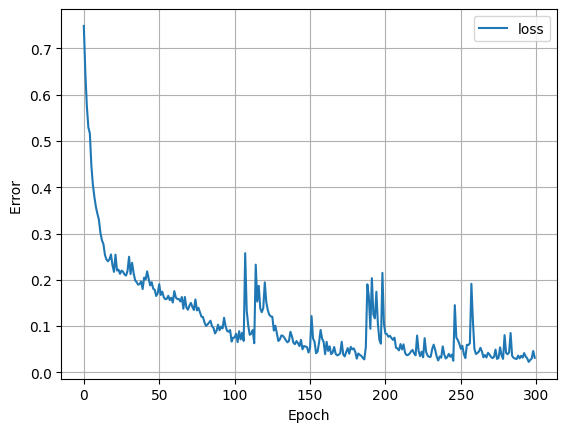

85/85 - 0s - loss: 2.3708 - accuracy: 0.6978 - 295ms/epoch - 3ms/step
Model accuracy: 0.6978123784065247
85/85 [==============================] - 0s 3ms/step - loss: 2.3708 - accuracy: 0.6978
Loss: 2.370793342590332
Accuracy: 0.6978123784065247
Precision: 0.17758369723435224
Recall: 0.3279569892473118


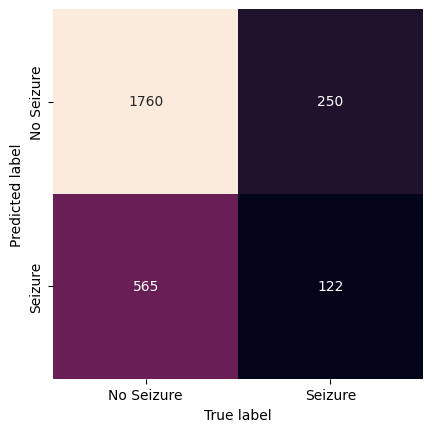

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.81      2325
         1.0       0.18      0.33      0.23       372

    accuracy                           0.70      2697
   macro avg       0.53      0.54      0.52      2697
weighted avg       0.78      0.70      0.73      2697



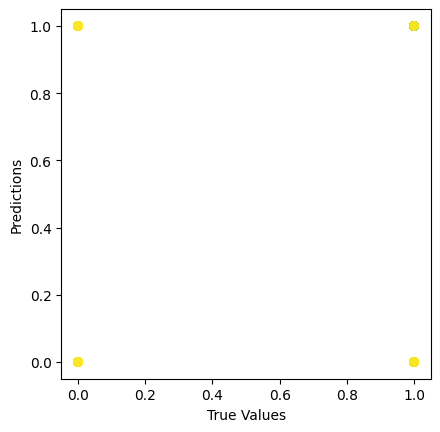

Epoch 1/300
108/108 [==============================] - 1s 4ms/step - loss: 0.6655 - accuracy: 0.5543
Epoch 2/300
108/108 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5991
Epoch 3/300
108/108 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6097
Epoch 4/300
108/108 [==============================] - 0s 4ms/step - loss: 0.5875 - accuracy: 0.6579
Epoch 5/300
108/108 [==============================] - 0s 4ms/step - loss: 0.5677 - accuracy: 0.6739
Epoch 6/300
108/108 [==============================] - 0s 4ms/step - loss: 0.5552 - accuracy: 0.6824
Epoch 7/300
108/108 [==============================] - 0s 4ms/step - loss: 0.5489 - accuracy: 0.6808
Epoch 8/300
108/108 [==============================] - 0s 4ms/step - loss: 0.5353 - accuracy: 0.7142
Epoch 9/300
108/108 [==============================] - 0s 4ms/step - loss: 0.5210 - accuracy: 0.7342
Epoch 10/300
108/108 [==============================] - 0s 4ms/step - loss: 0.5225 - accura

85/85 [==============================] - 0s 1ms/step
85/85 - 0s - loss: 0.9126 - accuracy: 0.5121 - 202ms/epoch - 2ms/step
Model accuracy: 0.512050449848175
85/85 [==============================] - 0s 1ms/step - loss: 0.9126 - accuracy: 0.5121
Loss: 0.9126222729682922
Accuracy: 0.512050449848175
Precision: 0.12420382165605096
Recall: 0.41935483870967744


In [7]:
%run model_rnn.ipynb